In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 1
commitnumber = d62b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 257
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

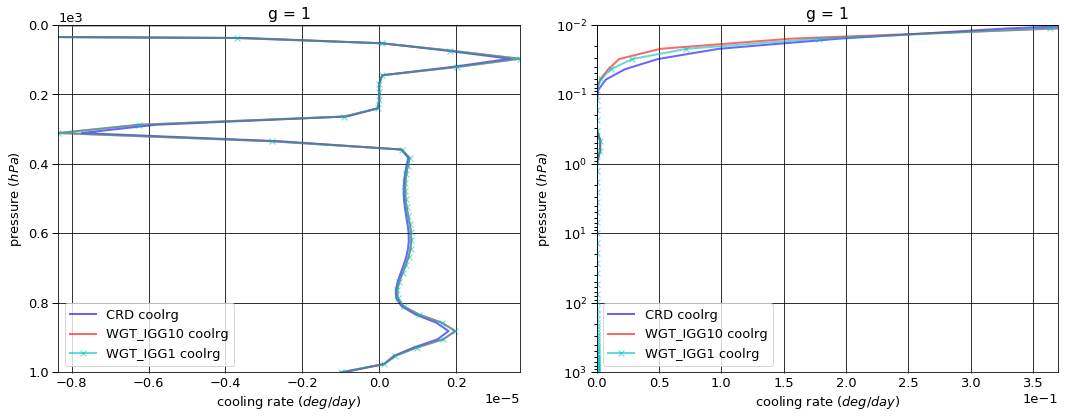

# Figure: cooling rate g-group 2

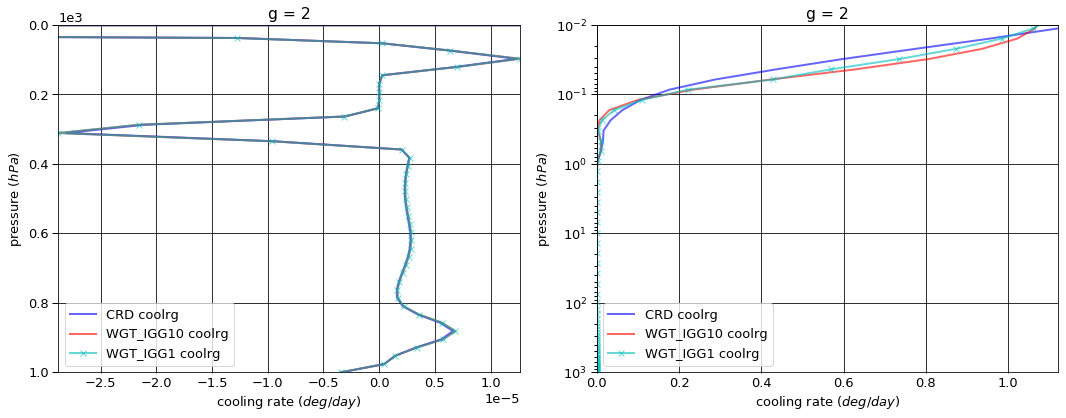

# Figure: cooling rate g-group 3

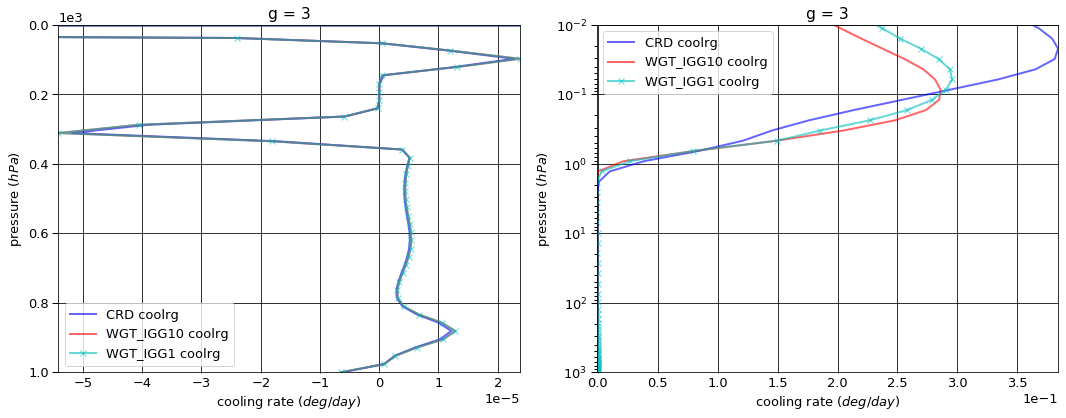

# Figure: cooling rate g-group 4

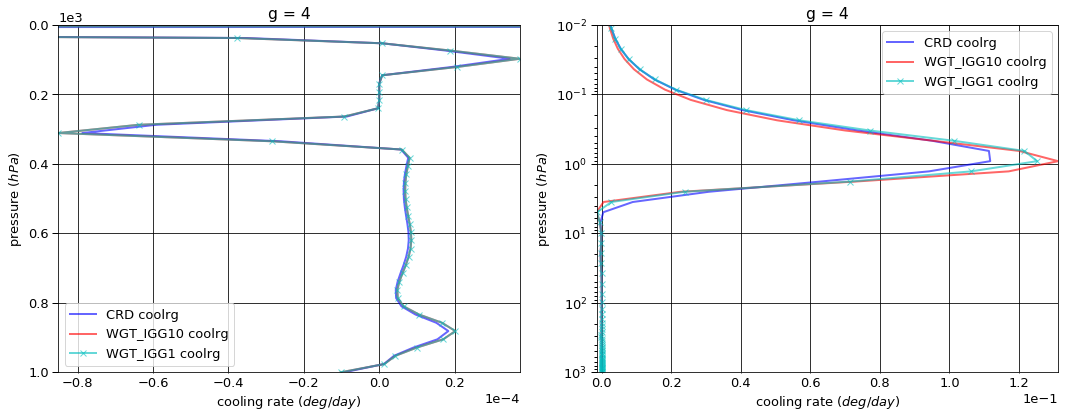

# Figure: cooling rate g-group 5

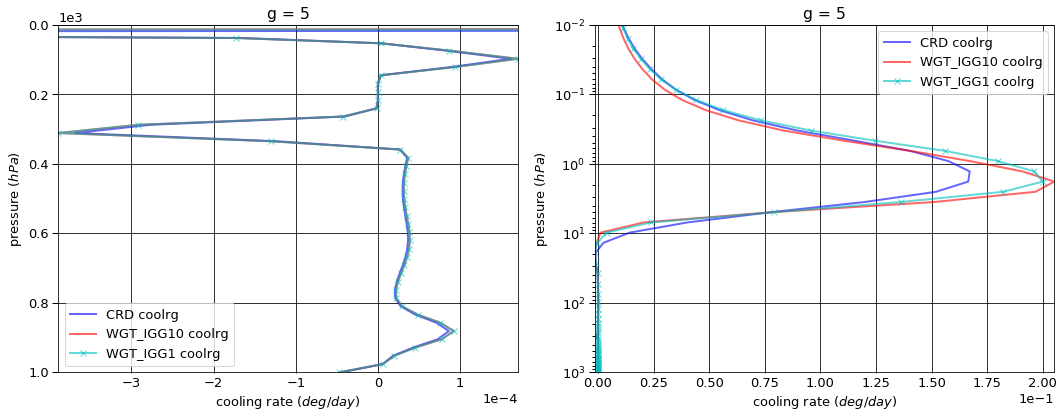

# Figure: cooling rate g-group 6

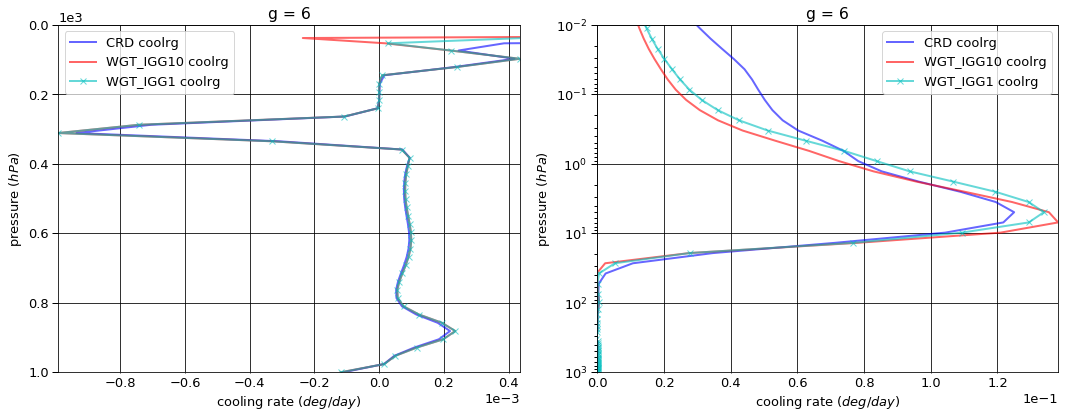

# Figure: cooling rate g-group 7

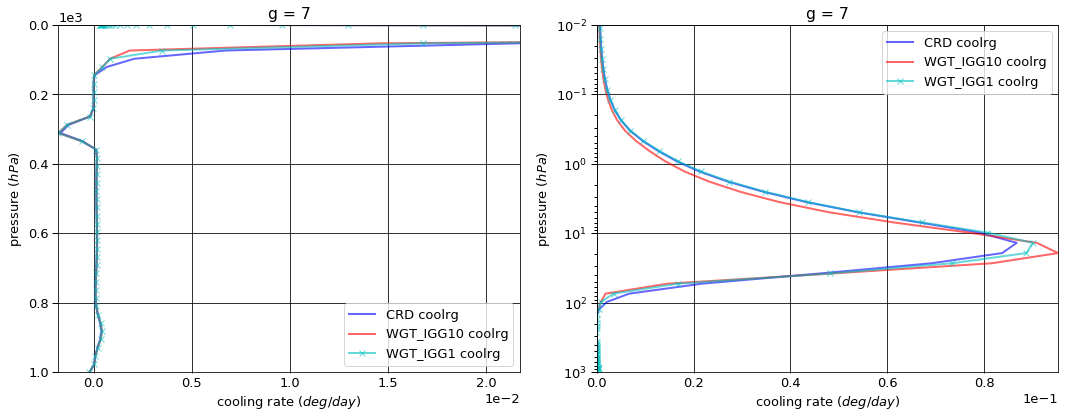

# Figure: cooling rate g-group 8

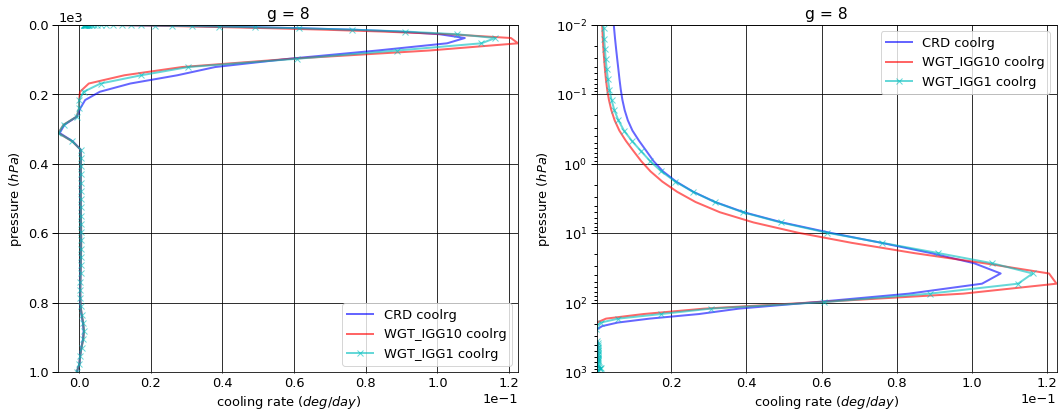

# Figure: cooling rate g-group 9

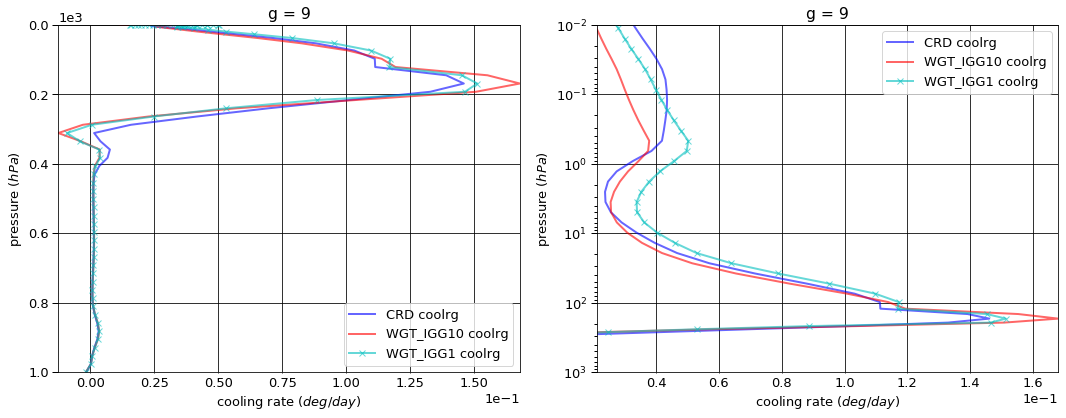

# Figure: cooling rate g-group 10

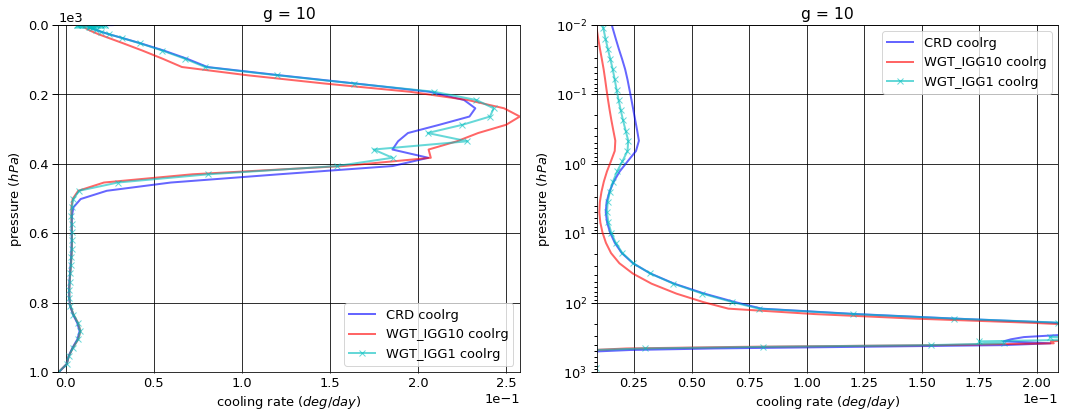

# Figure: cooling rate g-group 11

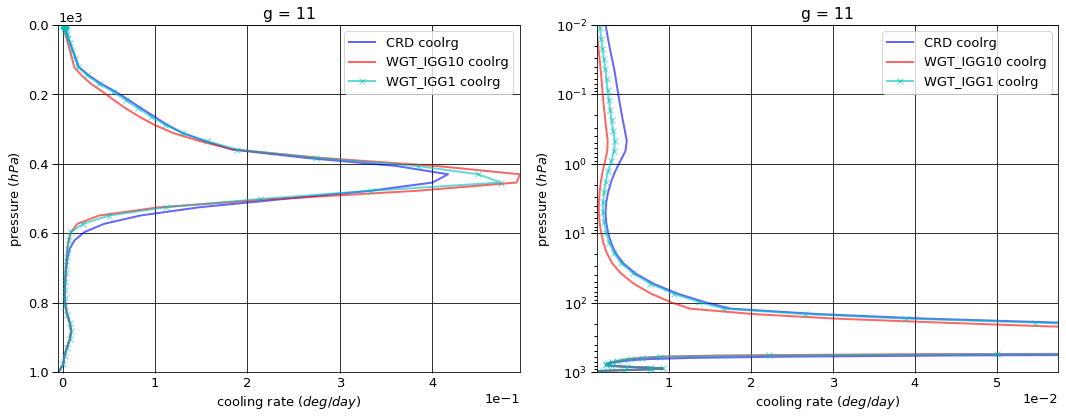

# Figure: cooling rate g-group 12

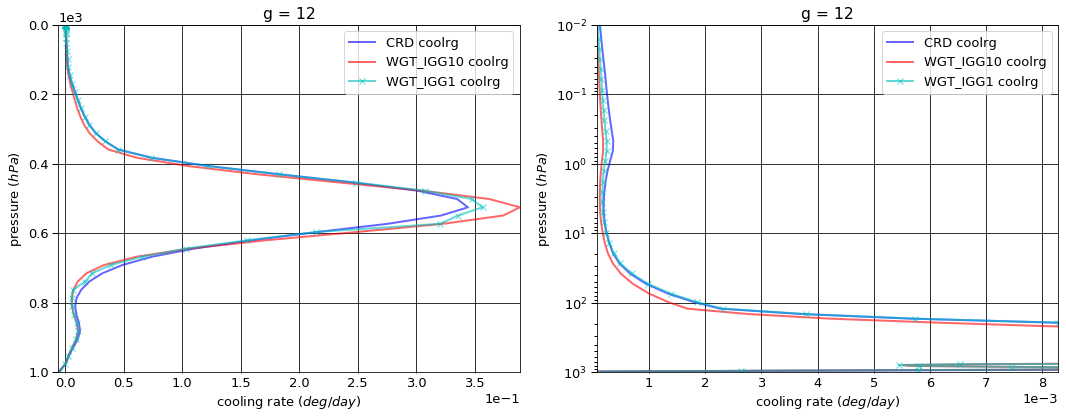

# Figure: cooling rate g-group total

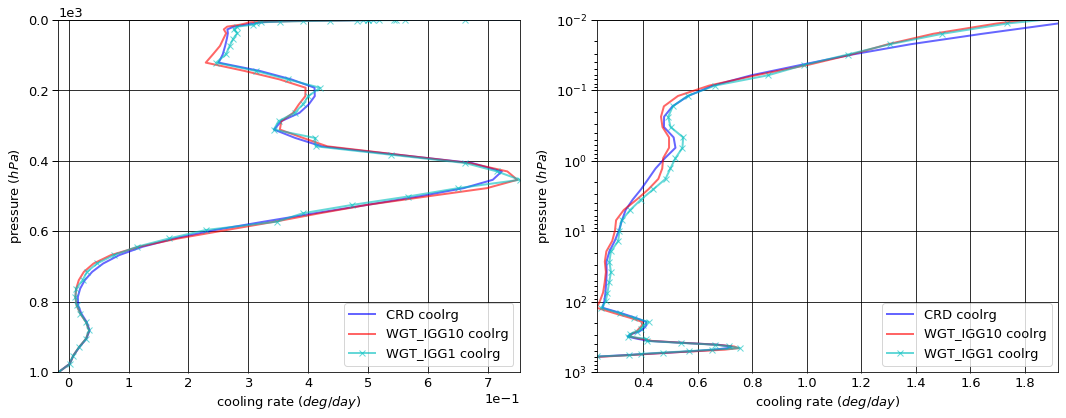

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002006   0.000000 -0.002006
   1013.0   76     -0.002554   0.002560  0.000006
2  0.0      1      -0.007786   0.000000 -0.007786
   1013.0   76     -0.008832   0.008853  0.000022
3  0.0      1      -0.015912   0.000000 -0.015912
   1013.0   76     -0.016596   0.016636  0.000040
4  0.0      1      -0.023952   0.000000 -0.023952
   1013.0   76     -0.026050   0.026110  0.000061
5  0.0      1      -0.098813   0.000000 -0.098813
   1013.0   76     -0.119150   0.119435  0.000285
6  0.0      1      -0.230031   0.000000 -0.230031
   1013.0   76     -0.303506   0.304228  0.000722
7  0.0      1      -0.400465   0.000000 -0.400465
   1013.0   76     -0.550255   0.551557  0.001302
8  0.0      1      -1.297887   0.000000 -1.297887
   1013.0   76     -1.773768   1.777959  0.004192
9  0.0      1      -3.333321   0.000000 -3.333321
   1013.0   76     -4.506658   4.517334  0.010676
10 0.0      1      -8.170298   0.000000 -8.170298
   1013.0   76    -10.785854  10.811727  0.025873
11 0.0      1      -9.580327   0.000000 -9.580327
   1013.0   76    -11.914127  11.944704  0.030577
12 0.0      1      -8.784895   0.000000 -8.784895
   1013.0   76    -10.254119  10.293910  0.039792


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.001969   0.000000 -0.001969
   1013.0   76     -0.002565   0.002572  0.000007
2  0.0      1      -0.007814   0.000000 -0.007814
   1013.0   76     -0.008845   0.008867  0.000023
3  0.0      1      -0.016143   0.000000 -0.016143
   1013.0   76     -0.016638   0.016680  0.000042
4  0.0      1      -0.024176   0.000000 -0.024176
   1013.0   76     -0.026165   0.026232  0.000067
5  0.0      1      -0.099355   0.000000 -0.099355
   1013.0   76     -0.119518   0.119822  0.000304
6  0.0      1      -0.226487   0.000000 -0.226487
   1013.0   76     -0.304520   0.305295  0.000775
7  0.0      1      -0.390574   0.000000 -0.390574
   1013.0   76     -0.552234   0.553640  0.001405
8  0.0      1      -1.266102   0.000000 -1.266102
   1013.0   76     -1.780269   1.784800  0.004530
9  0.0      1      -3.263600   0.000000 -3.263600
   1013.0   76     -4.522657   4.534166  0.011509
10 0.0      1      -8.001450   0.000000 -8.001450
   1013.0   76    -10.817618  10.845147  0.027528
11 0.0      1      -9.568999   0.000000 -9.568999
   1013.0   76    -11.916154  11.946497  0.030343
12 0.0      1      -8.913951   0.000000 -8.913951
   1013.0   76    -10.194284  10.229091  0.034807


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.001972   0.000000 -0.001972
   1013.0   76     -0.002565   0.002572  0.000007
2  0.0      1      -0.007809   0.000000 -0.007809
   1013.0   76     -0.008845   0.008867  0.000023
3  0.0      1      -0.016098   0.000000 -0.016098
   1013.0   76     -0.016638   0.016680  0.000042
4  0.0      1      -0.024136   0.000000 -0.024136
   1013.0   76     -0.026165   0.026232  0.000067
5  0.0      1      -0.099404   0.000000 -0.099404
   1013.0   76     -0.119518   0.119822  0.000304
6  0.0      1      -0.226957   0.000000 -0.226957
   1013.0   76     -0.304520   0.305295  0.000775
7  0.0      1      -0.391387   0.000000 -0.391387
   1013.0   76     -0.552234   0.553640  0.001405
8  0.0      1      -1.267059   0.000000 -1.267059
   1013.0   76     -1.780269   1.784800  0.004530
9  0.0      1      -3.261630   0.000000 -3.261630
   1013.0   76     -4.522657   4.534166  0.011509
10 0.0      1      -7.996537   0.000000 -7.996537
   1013.0   76    -10.817618  10.845147  0.027528
11 0.0      1      -9.524665   0.000000 -9.524665
   1013.0   76    -11.916154  11.946487  0.030333
12 0.0      1      -8.870636   0.000000 -8.870636
   1013.0   76    -10.194284  10.229084  0.034800


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000038  0.000000  3.768290e-05
   1013.0   76    -0.000011  0.000012  5.730796e-07
2  0.0      1     -0.000028  0.000000 -2.752790e-05
   1013.0   76    -0.000013  0.000014  6.970780e-07
3  0.0      1     -0.000231  0.000000 -2.308020e-04
   1013.0   76    -0.000042  0.000044  2.195580e-06
4  0.0      1     -0.000225  0.000000 -2.245530e-04
   1013.0   76    -0.000116  0.000122  6.038123e-06
5  0.0      1     -0.000542  0.000000 -5.417430e-04
   1013.0   76    -0.000367  0.000387  1.914597e-05
6  0.0      1      0.003544  0.000000  3.544220e-03
   1013.0   76    -0.001014  0.001066  5.281694e-05
7  0.0      1      0.009891  0.000000  9.890560e-03
   1013.0   76    -0.001979  0.002082  1.032299e-04
8  0.0      1      0.031785  0.000000  3.178460e-02
   1013.0   76    -0.006502  0.006841  3.386557e-04
9  0.0      1      0.069721  0.000000  6.972150e-02
   1013.0   76    -0.015999  0.016832  8.336130e-04
10 0.0      1      0.168847  0.000000  1.688474e-01
   1013.0   76    -0.031764  0.033420  1.655346e-03
11 0.0      1      0.011327  0.000000  1.132740e-02
   1013.0   76    -0.002027  0.001793 -2.346490e-04
12 0.0      1     -0.129056  0.000000 -1.290556e-01
   1013.0   76     0.059835 -0.064819 -4.984778e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000035  0.000000  3.452400e-05
   1013.0   76    -0.000011  0.000012  5.730796e-07
2  0.0      1     -0.000023  0.000000 -2.282440e-05
   1013.0   76    -0.000013  0.000014  6.970780e-07
3  0.0      1     -0.000186  0.000000 -1.855800e-04
   1013.0   76    -0.000042  0.000044  2.195580e-06
4  0.0      1     -0.000184  0.000000 -1.842300e-04
   1013.0   76    -0.000116  0.000122  6.038123e-06
5  0.0      1     -0.000590  0.000000 -5.903810e-04
   1013.0   76    -0.000367  0.000387  1.914597e-05
6  0.0      1      0.003074  0.000000  3.074490e-03
   1013.0   76    -0.001014  0.001066  5.281694e-05
7  0.0      1      0.009078  0.000000  9.077800e-03
   1013.0   76    -0.001979  0.002082  1.032299e-04
8  0.0      1      0.030828  0.000000  3.082810e-02
   1013.0   76    -0.006502  0.006841  3.386557e-04
9  0.0      1      0.071691  0.000000  7.169100e-02
   1013.0   76    -0.015999  0.016832  8.336130e-04
10 0.0      1      0.173760  0.000000  1.737605e-01
   1013.0   76    -0.031764  0.033420  1.655346e-03
11 0.0      1      0.055662  0.000000  5.566190e-02
   1013.0   76    -0.002027  0.001783 -2.442040e-04
12 0.0      1     -0.085741  0.000000 -8.574130e-02
   1013.0   76     0.059835 -0.064826 -4.991505e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.365229e+00
   1001.112500 75    -9.146702e-07
2  0.000312    1      1.410366e+00
   1001.112500 75    -3.351322e-06
3  0.000312    1      1.910313e-01
   1001.112500 75    -6.167720e-06
4  0.000312    1      1.657233e-04
   1001.112500 75    -9.299739e-06
5  0.000312    1      2.672375e-03
   1001.112500 75    -4.378397e-05
6  0.000312    1      1.147327e-02
   1001.112500 75    -1.109346e-04
7  0.000312    1      3.239748e-04
   1001.112500 75    -2.000191e-04
8  0.000312    1      3.100848e-03
   1001.112500 75    -6.439333e-04
9  0.000312    1      1.783032e-02
   1001.112500 75    -1.639978e-03
10 0.000312    1      7.929548e-03
   1001.112500 75    -3.974851e-03
11 0.000312    1      1.065874e-03
   1001.112500 75    -4.720696e-03
12 0.000312    1      4.770296e-05
   1001.112500 75    -5.997214e-03


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      2.615532
   1001.112500 75    -0.000001
2  0.000312    1      0.714701
   1001.112500 75    -0.000003
3  0.000312    1      0.087002
   1001.112500 75    -0.000007
4  0.000312    1      0.000158
   1001.112500 75    -0.000010
5  0.000312    1      0.002832
   1001.112500 75    -0.000047
6  0.000312    1      0.005677
   1001.112500 75    -0.000119
7  0.000312    1      0.000256
   1001.112500 75    -0.000216
8  0.000312    1      0.001033
   1001.112500 75    -0.000696
9  0.000312    1      0.011678
   1001.112500 75    -0.001769
10 0.000312    1      0.004554
   1001.112500 75    -0.004231
11 0.000312    1      0.000530
   1001.112500 75    -0.004664
12 0.000312    1      0.000025
   1001.112500 75    -0.005544


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.941174
   1001.112500 75    -0.000001
2  0.000312    1      0.883462
   1001.112500 75    -0.000003
3  0.000312    1      0.108487
   1001.112500 75    -0.000007
4  0.000312    1      0.000183
   1001.112500 75    -0.000010
5  0.000312    1      0.003233
   1001.112500 75    -0.000047
6  0.000312    1      0.006571
   1001.112500 75    -0.000119
7  0.000312    1      0.000303
   1001.112500 75    -0.000216
8  0.000312    1      0.001237
   1001.112500 75    -0.000696
9  0.000312    1      0.015535
   1001.112500 75    -0.001769
10 0.000312    1      0.006102
   1001.112500 75    -0.004231
11 0.000312    1      0.000727
   1001.112500 75    -0.004660
12 0.000312    1      0.000035
   1001.112500 75    -0.005392


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.749698e+00
   1001.112500 75    -8.855736e-08
2  0.000312    1     -6.956649e-01
   1001.112500 75    -1.077746e-07
3  0.000312    1     -1.040293e-01
   1001.112500 75    -3.390612e-07
4  0.000312    1     -7.699040e-06
   1001.112500 75    -9.331720e-07
5  0.000312    1      1.599622e-04
   1001.112500 75    -2.957564e-06
6  0.000312    1     -5.796555e-03
   1001.112500 75    -8.158290e-06
7  0.000312    1     -6.782464e-05
   1001.112500 75    -1.595112e-05
8  0.000312    1     -2.068330e-03
   1001.112500 75    -5.230211e-05
9  0.000312    1     -6.151984e-03
   1001.112500 75    -1.287619e-04
10 0.000312    1     -3.375704e-03
   1001.112500 75    -2.557496e-04
11 0.000312    1     -5.358427e-04
   1001.112500 75     5.648670e-05
12 0.000312    1     -2.235651e-05
   1001.112500 75     4.533900e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.424055e+00
   1001.112500 75    -8.855736e-08
2  0.000312    1     -5.269036e-01
   1001.112500 75    -1.077746e-07
3  0.000312    1     -8.254418e-02
   1001.112500 75    -3.390612e-07
4  0.000312    1      1.748930e-05
   1001.112500 75    -9.331720e-07
5  0.000312    1      5.605737e-04
   1001.112500 75    -2.957564e-06
6  0.000312    1     -4.902019e-03
   1001.112500 75    -8.158290e-06
7  0.000312    1     -2.124884e-05
   1001.112500 75    -1.595112e-05
8  0.000312    1     -1.863775e-03
   1001.112500 75    -5.230211e-05
9  0.000312    1     -2.295071e-03
   1001.112500 75    -1.287619e-04
10 0.000312    1     -1.827830e-03
   1001.112500 75    -2.557496e-04
11 0.000312    1     -3.384918e-04
   1001.112500 75     6.055350e-05
12 0.000312    1     -1.242880e-05
   1001.112500 75     6.051286e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.945693,0.000000,-31.945693
1013.0,76,-40.261469,40.375015,0.113547



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.780620,0.000000,-31.78062
1013.0,76,-40.261467,40.372808,0.11134



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.688289,0.000000,-31.688289
1013.0,76,-40.261467,40.372791,0.111324



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.165073,0.000000,0.165073
1013.0,76,0.000001,-0.002206,-0.002207



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.257404,0.000000,0.257404
1013.0,76,0.000001,-0.002223,-0.002223


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.011237
1001.112500,75,-0.017351



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.443978
1001.112500,75,-0.017307



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.967051
1001.112500,75,-0.017151



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.567258
1001.112500,75,0.000045



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.044186
1001.112500,75,0.000200


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
